In [4]:
# !pip install wget
#!pip install tensorboard
import wget, os, gzip, pickle, random, re, sys
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from random import shuffle

In [5]:
IMDB_URL = 'http://dlvu.github.io/data/imdb.{}.pkl.gz'
IMDB_FILE = 'imdb.{}.pkl.gz'
PAD, START, END, UNK = '.pad', '.start', '.end', '.unk'

In [6]:
def load_imdb(final=False, val=5000, seed=0, voc=None, char=False):

    cst = 'char' if char else 'word'

    imdb_url = IMDB_URL.format(cst)
    imdb_file = IMDB_FILE.format(cst)

    if not os.path.exists(imdb_file):
        wget.download(imdb_url)

    with gzip.open(imdb_file) as file:
        sequences, labels, i2w, w2i = pickle.load(file)

    if voc is not None and voc < len(i2w):
        nw_sequences = {}

        i2w = i2w[:voc]
        w2i = {w: i for i, w in enumerate(i2w)}

        mx, unk = voc, w2i['.unk']
        for key, seqs in sequences.items():
            nw_sequences[key] = []
            for seq in seqs:
                seq = [s if s < mx else unk for s in seq]
                nw_sequences[key].append(seq)

        sequences = nw_sequences

    if final:
        return (sequences['train'], labels['train']), (sequences['test'], labels['test']), (i2w, w2i), 2

    # Make a validation split
    random.seed(seed)

    x_train, y_train = [], []
    x_val, y_val = [], []

    val_ind = set( random.sample(range(len(sequences['train'])), k=val) )
    for i, (s, l) in enumerate(zip(sequences['train'], labels['train'])):
        if i in val_ind:
            x_val.append(s)
            y_val.append(l)
        else:
            x_train.append(s)
            y_train.append(l)

    return (x_train, y_train), \
           (x_val, y_val), \
           (i2w, w2i), 2

In [4]:
def gen_sentence(sent, g):

    symb = '_[a-z]*'

    while True:

        match = re.search(symb, sent)
        if match is None:
            return sent

        s = match.span()
        sent = sent[:s[0]] + random.choice(g[sent[s[0]:s[1]]]) + sent[s[1]:]


In [5]:
def gen_dyck(p):
    open = 1
    sent = '('
    while open > 0:
        if random.random() < p:
            sent += '('
            open += 1
        else:
            sent += ')'
            open -= 1

    return sent

In [6]:
def gen_ndfa(p):

    word = random.choice(['abc!', 'uvw!', 'klm!'])

    s = ''
    while True:
        if random.random() < p:
            return 's' + s + 's'
        else:
            s+= word

In [7]:
def load_brackets(n=50_000, seed=0):
    return load_toy(n, char=True, seed=seed, name='dyck')

def load_ndfa(n=50_000, seed=0):
    return load_toy(n, char=True, seed=seed, name='ndfa')

def load_toy(n=50_000, char=True, seed=0, name='lang'):
    
    random.seed(0)

    if name == 'lang':
        sent = '_s'

        toy = {
            '_s': ['_s _adv', '_np _vp', '_np _vp _prep _np', '_np _vp ( _prep _np )', '_np _vp _con _s' , '_np _vp ( _con _s )'],
            '_adv': ['briefly', 'quickly', 'impatiently'],
            '_np': ['a _noun', 'the _noun', 'a _adj _noun', 'the _adj _noun'],
            '_prep': ['on', 'with', 'to'],
            '_con' : ['while', 'but'],
            '_noun': ['mouse', 'bunny', 'cat', 'dog', 'man', 'woman', 'person'],
            '_vp': ['walked', 'walks', 'ran', 'runs', 'goes', 'went'],
            '_adj': ['short', 'quick', 'busy', 'nice', 'gorgeous']
        }

        sentences = [ gen_sentence(sent, toy) for _ in range(n)]
        sentences.sort(key=lambda s : len(s))

    elif name == 'dyck':

        sentences = [gen_dyck(7./16.) for _ in range(n)]
        sentences.sort(key=lambda s: len(s))

    elif name == 'ndfa':

        sentences = [gen_ndfa(1./4.) for _ in range(n)]
        sentences.sort(key=lambda s: len(s))

    else:
        raise Exception(name)

    tokens = set()
    for s in sentences:

        if char:
            for c in s:
                tokens.add(c)
        else:
            for w in s.split():
                tokens.add(w)

    i2t = [PAD, START, END, UNK] + list(tokens)
    t2i = {t:i for i, t in enumerate(i2t)}

    sequences = []
    for s in sentences:
        if char:
            tok = list(s)
        else:
            tok = s.split()
        sequences.append([t2i[t] for t in tok])

    return sequences, (i2t, t2i)

In [7]:
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)
pad_index = w2i[PAD]
print(len(x_val))

5000


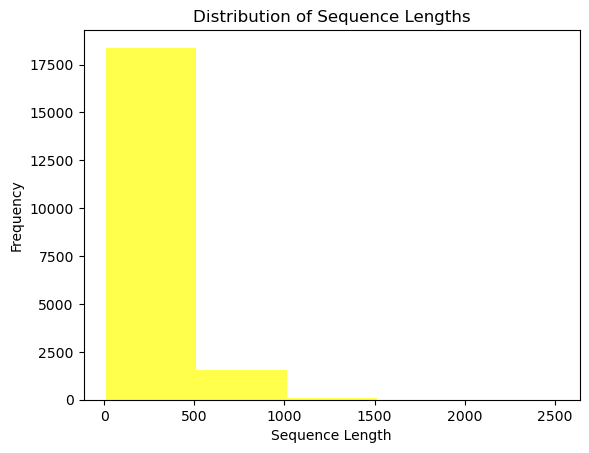

In [8]:
review_lengths = [len(review) for review in x_train]
plt.hist(review_lengths, bins = 5, color='yellow', alpha=0.7)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

1708


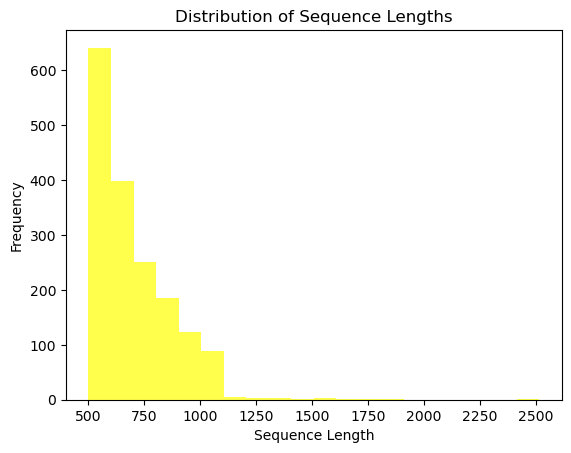

In [9]:
long_length = [len(review) for review in x_train if len(review) > 500]
print(len(long_length))
plt.hist(long_length, bins = 20, color='yellow', alpha=0.7)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

We have significantly big large amount of reviews with length between 0 and 500 -> 17500. Around 2400 reviews have length between 500 and 1000. The rest has length between 1000 and 2500.

In [14]:
def add_padding(curr_sequences, pad_index):
    # change to the get max length functioin?
    max_length = len(curr_sequences[-1])
    padded_sequences = []
    for i in range(len(curr_sequences)):
        length_to_pad = max_length - len(curr_sequences[i])
        curr_sequences[:800]
        padded_sequences.append(curr_sequences[i] + [pad_index] * length_to_pad)
    return padded_sequences

In [15]:
def split_into_batches(reviews_labeled, batch_size):
    batches_padded_labeled = []
    for idx in range(0, len(reviews_labeled), batch_size):
        # print(f"Index {idx}: ")
        curr_batch = reviews_labeled[idx:(idx + batch_size)]
        curr_reviews, curr_labels = zip(*curr_batch)
        batches_padded_labeled.append((add_padding(curr_reviews, pad_index), curr_labels))
    return batches_padded_labeled

In [136]:
def dynamic_batching_2(reviews, labels, max_length, max_batch_tokens, pad_index):
    proccessed_batches = []
    curr_batch = []
    token_count = 0
    # num_batches = -1
    longest_review = 0
    for review, label in zip(reversed(reviews), reversed(labels)):
        if token_count == 0:
            longest_review = len(review)
            print(f"Longest review: {longest_review}")
            print(f"Numb_batches: {max_batch_tokens / longest_review}")
            
        if len(review) > longest_review:  
            processed_review = review[:max_length]
        else:
            length_to_pad = longest_review - len(review)
            processed_review = review + [pad_index] * length_to_pad
        
        curr_batch.append((processed_review, label))
        token_count += longest_review
        
        if token_count > max_batch_tokens:
            proccessed_batches.append(curr_batch)
            curr_batch = []
            token_count = 0
     
    if curr_batch:
        proccessed_batches.append(curr_batch)
    
    return proccessed_batches

In [123]:
def dynamic_batching(reviews, labels, max_token_short, max_token_long, pad_index):
    max_token = max_token_short
    batches = []
    current_batch = []
    batch_count = 0
    num_batches = -1
    for review, label in zip(reversed(reviews), reversed(labels)):
        
        if num_batches == -1:
            longest_review = len(review)
            print(f"Longest review: {longest_review}")
            if len(review) > max_token // 2 and len(current_batch) == 0:
                truncated_length = min(max_token_short, longest_review)
                num_batches = max_token_long // max_token_short
            else:
                truncated_length = longest_review
                num_batches = max_token // longest_review 
            print(f"Numb_batches: {num_batches}")
                
        processed_review = []
        if len(review) > truncated_length:  
            processed_review = review[:truncated_length]
        else:
            length_to_pad = truncated_length - len(review)
            processed_review = review + [pad_index] * length_to_pad
            
        current_batch.append((processed_review, label))
        batch_count += 1
        print(f"Curr abtch count: {batch_count}")
        
        if(batch_count >= num_batches):
            print(f"Batch created: {len(current_batch)}")
            batches.append(current_batch)
            num_batches = -1
            current_batch = []
            batch_count = 0
    
    if current_batch:  
        batches.append(current_batch)
    
    return batches[::-1]

In [135]:
# def create_tensors(reviews, labels, max_length, max_batch_tokens, pad_index):
    
#     # reviews_and_labels = list(zip(reviews, labels))
#     batches_labeled = dynamic_batching_2(reviews, labels, max_length, max_batch_tokens, pad_index)
    
#     shuffle(batches_labeled)
#     tensor_batches = [
#         (torch.tensor([review for review, _ in batch], dtype=torch.long), 
#          torch.tensor([label for _, label in batch], dtype=torch.long))
#         for batch in batches_labeled
#     ]
#     return tensor_batches

In [10]:
def create_fixed_batches(reviews, labels, batch_size, max_seq_length, pad_index):
    batches = []
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        padded_reviews = [review[:max_seq_length] + [pad_index] * max(0, max_seq_length - len(review)) for review in batch_reviews]
        batches.append((padded_reviews, batch_labels))
    return batches

In [11]:
def create_tensors(reviews, labels, batch_size, max_seq_length, pad_index):
    batches_labeled = create_fixed_batches(reviews, labels, batch_size, max_seq_length, pad_index)
    
    shuffle(batches_labeled)
    tensor_batches = [
        (torch.tensor(padded_reviews, dtype=torch.long), torch.tensor(batch_labels, dtype=torch.long))
        for padded_reviews, batch_labels in batches_labeled
    ]
    return tensor_batches

Total sequences before processing: 20000
313


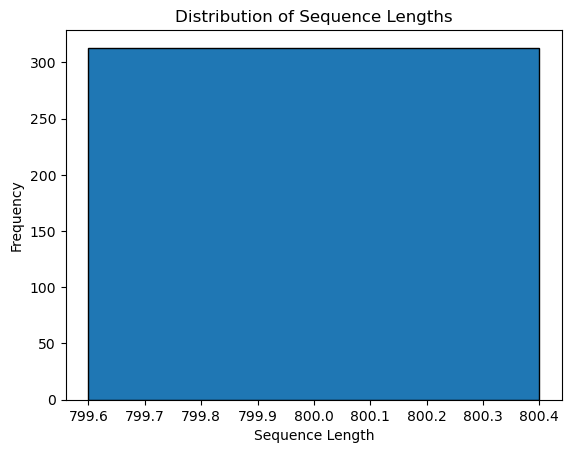

In [13]:
from collections import Counter
total_sequences_before = len(x_train)
print(f"Total sequences before processing: {total_sequences_before}")

tensors = create_tensors(x_train, y_train, 64, 800, pad_index)
sequence_lengths = [sequences.size(1) for sequences, _ in tensors]
# Print the distribution (count the frequency of each length)
length_counts = Counter(sequence_lengths)
print(len(tensors))

total_sequences_after = sum(len(batch[0]) for batch in tensors)
# print(f"Distribution of sequence lengths: {dict(length_counts)}")


# Plot the distribution
plt.bar(length_counts.keys(), length_counts.values(), edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [87]:
tensor_batches_val = create_tensors(x_train, y_train, 128)
print(tensor_batches_val[0][0])
for review, label in tensor_batches_val:
    print(review.shape)

tensor([[  418,   194,     8,  ...,   608,   492,     0],
        [   13,   511,    14,  ..., 11493,  8091,     0],
        [  334,    32,     7,  ...,   539,  1125,     0],
        ...,
        [   13,   234,   456,  ...,    68,   380,    11],
        [   38,   322,   816,  ...,    49,    24,    54],
        [  261,   311,  4559,  ...,     5,    53,   312]])
torch.Size([128, 146])
torch.Size([128, 429])
torch.Size([128, 154])
torch.Size([128, 129])
torch.Size([128, 316])
torch.Size([128, 211])
torch.Size([128, 537])
torch.Size([128, 701])
torch.Size([128, 804])
torch.Size([128, 137])
torch.Size([128, 488])
torch.Size([128, 138])
torch.Size([128, 171])
torch.Size([128, 183])
torch.Size([128, 111])
torch.Size([128, 340])
torch.Size([128, 360])
torch.Size([128, 159])
torch.Size([128, 274])
torch.Size([128, 40])
torch.Size([128, 518])
torch.Size([128, 105])
torch.Size([128, 322])
torch.Size([128, 193])
torch.Size([128, 333])
torch.Size([128, 174])
torch.Size([128, 162])
torch.Size([128, 1

In [14]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedd_dim, hidden_dim, numcls):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedd_dim)
        self.linear1 = nn.Linear(embedd_dim, hidden_dim)
        self.activation1 = nn.ReLU()
        #dropout or no dropout?
        self.drop1 = nn.Dropout(0.3)
        
        self.classifier = nn.Linear(hidden_dim, numcls)
        
    def forward(self, x):
        #input (batch, sequence length)
        #output (batch, sequence length, hidden)
        
        # print("Input shape: ", x.shape)
        x = self.embedding(x)
        
        x = self.activation1(self.linear1(x))
        # print("Output of linear1 and activation1 shape: ", x.shape)
        x = self.drop1(x)
        
        # input (batch, sequence length, hidden)
        # output (batch, embedd_dim)
        x, _ = torch.max(x, dim=1)
        # print("Output of max-pooling shape: ", x.shape)
        
        # print("Activation statistics: ", x.min(), x.max(), x.mean())
        
        x = self.classifier(x)
        return x

In [88]:
class SimpleSelfAtention(nn.Module):
    def __init__(self, vocab_size, embedd_dim, hidden_dim, numcls):
        super().__init__()
        self.embedd_dim = embedd_dim
        self.embedding = nn.Embedding(vocab_size, embedd_dim)  
        
        self.w_q = nn.Linear(embedd_dim, embedd_dim, bias = False)
        self.w_k = nn.Linear(embedd_dim, embedd_dim, bias = False)
        self.w_v = nn.Linear(embedd_dim, embedd_dim, bias = False)
        
        self.linear1 = nn.Linear(embedd_dim, hidden_dim)
        self.activation1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        
        self.classifier = nn.Linear(embedd_dim, numcls)
        
    @staticmethod    
    def attention(query, key, value):
        embedded_dim = query.shape[-1]
        #(batch, seq_length, embed_dim) ---> (batch, seq_length, seq_length)
        attention_scores = torch.bmm(query, key.transpose(1, 2)) / np.sqrt(embedded_dim)
    
        attention_scores = F.softmax(attention_scores, dim=-1)
        
        return torch.bmm(attention_scores, value), attention_scores
    
        
    def forward(self, x):
        # (b, s) ---> (b, s, e) 
        x = self.embedding(x) 
        batch_size, sequence_length, embedded_dim = x.size()
        
        Q = self.w_q(x)
        K = self.w_k(x)
        V = self.w_v(x)
        
        attention_output, self.attention_scores = SimpleSelfAtention.attention(Q, K, V)
        ff_output = self.activation1(self.linear1(attention_output))
        ff_output, _ = torch.max(ff_output, 1)
        ff_output = self.drop1(ff_output)

        ff_output = self.classifier(ff_output)
        return ff_output

In [79]:
# vocab_size = len(i2w)
# embedded_dim = 300
# hidden_dim = 300
# num_epochs = 5
# batch_size = 64
# print_interval = 20

# model = SimpleSelfAtention(vocab_size, embedded_dim, hidden_dim, numcls)
# loss_func = nn.CrossEntropyLoss()
# # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr = 0.001)
# # writer = SummaryWriter('runs/imdb_experiment_1')

# tensor_batches_train = create_tensors(x_train, y_train, batch_size)
# tensor_batches_val = create_tensors(x_val, y_val, batch_size)

In [91]:
def compute_metrics(model, tensor_batches, loss_func):
    model.eval()
    correct_pred, num_examples, total_loss = 0, 0, 0
    with torch.no_grad():
        for reviews, labels in tensor_batches:
            outputs = model(reviews)
            loss = loss_func(outputs, labels)
            
            total_loss += loss.item() * reviews.size(0)
            _, predicted_labels = torch.max(outputs, 1)

            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
        avg_loss =  total_loss / num_examples
        accuracy = correct_pred.float()/num_examples * 100
    return avg_loss, accuracy

In [104]:
learning_rates = [0.001, 0.0001]
optimizers = ['Adam']
vocab_size = len(i2w)
embedded_dim = 300
hidden_dim = 300
num_epochs = 2
batch_size = 128
print_interval = 20

def get_optimizer(optimizer_name, model_parameters, lr):
    if optimizer_name == 'SGD':
        return optim.SGD(model_parameters, lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        return optim.Adam(model_parameters, lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

results = []

for optimizer_name in optimizers:
    for lr in learning_rates:
        print(f"Optimizer: {optimizer_name} with {lr} learning rate")
        model = SimpleSelfAtention(vocab_size, embedded_dim, hidden_dim, numcls)
        loss_func = nn.CrossEntropyLoss()
        # print(optimizer_name)
        optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
        
        train_losses = []
        val_accuracies = []
        # writer = SummaryWriter('runs/imdb_experiment_1')

        tensor_batches_train = create_tensors(x_train, y_train, batch_size)
        tensor_batches_val = create_tensors(x_val, y_val, batch_size)
        
        for epoch in range(num_epochs):
            model.train()
            curr_loss = 0
            for i, (reviews, labels) in enumerate(tensor_batches_train):
                outputs = model(reviews)
                loss = loss_func(outputs, labels)
                
                # backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
                if (i + 1) % print_interval == 0:
                    print(
                        f"Epoch [{epoch + 1} / {num_epochs}], "
                        f"Step [{i + 1}/{len(tensor_batches_train)}], "
                        f"Loss{loss.item(): .4f}"
                    )
                    
            train_loss, train_accuracy = compute_metrics(model, tensor_batches_train, loss_func)
            val_loss, val_accuracy = compute_metrics(model, tensor_batches_val, loss_func)
            val_accuracies.append(val_accuracy)
            train_losses.append(train_loss)
            
            print(
                f"Training Loss: {train_loss: .4f}, Training Accuracy: {train_accuracy:.2f}%"
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%"
            )
        results.append((optimizer_name, lr, train_losses, val_accuracies))

        

Optimizer: Adam with 0.001 learning rate
Epoch [1 / 2], Step [20/157], Loss 0.6281
Epoch [1 / 2], Step [40/157], Loss 0.5532
Epoch [1 / 2], Step [60/157], Loss 0.6860
Epoch [1 / 2], Step [80/157], Loss 0.7114
Epoch [1 / 2], Step [100/157], Loss 0.5701
Epoch [1 / 2], Step [120/157], Loss 0.4498
Epoch [1 / 2], Step [140/157], Loss 0.3841
Training Loss:  0.3735, Training Accuracy: 84.07%Validation Loss: 0.4197, Validation Accuracy: 81.24%
Epoch [2 / 2], Step [20/157], Loss 0.3265
Epoch [2 / 2], Step [40/157], Loss 0.2996
Epoch [2 / 2], Step [60/157], Loss 0.3224
Epoch [2 / 2], Step [80/157], Loss 0.3593
Epoch [2 / 2], Step [100/157], Loss 0.4175
Epoch [2 / 2], Step [120/157], Loss 0.3394
Epoch [2 / 2], Step [140/157], Loss 0.7499
Training Loss:  0.2525, Training Accuracy: 90.25%Validation Loss: 0.3723, Validation Accuracy: 84.10%
Optimizer: Adam with 0.0001 learning rate
Epoch [1 / 2], Step [20/157], Loss 0.6924
Epoch [1 / 2], Step [40/157], Loss 0.6568
Epoch [1 / 2], Step [60/157], Loss 

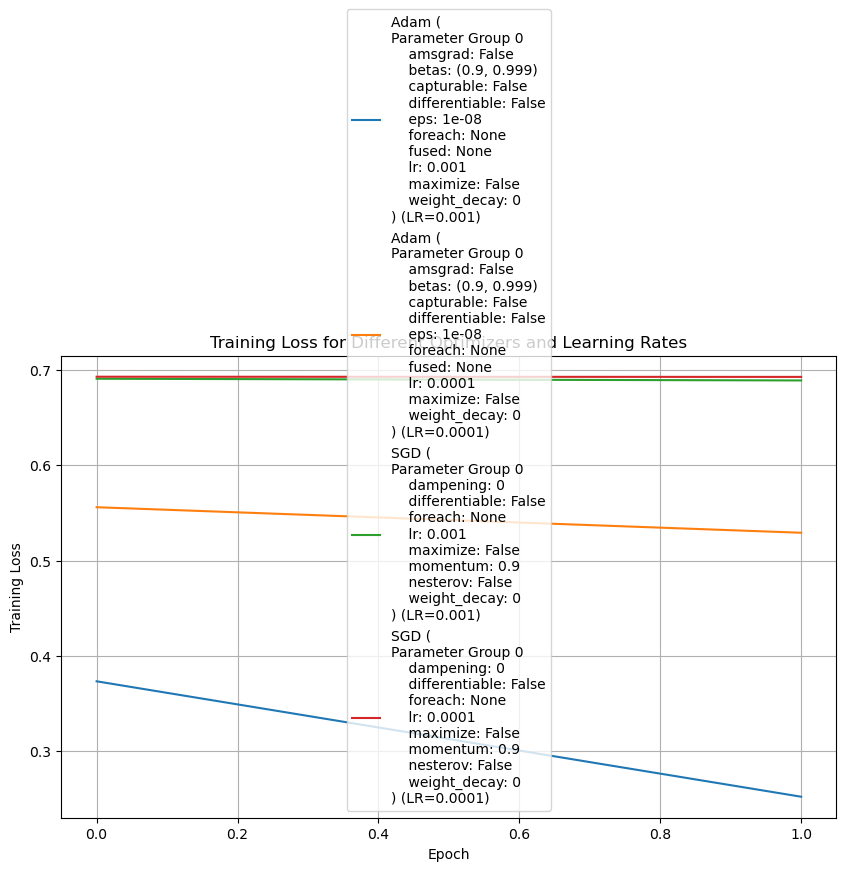

In [106]:
# Plotting all training losses
plt.figure(figsize=(10, 6))
for optimizer_name, lr, train_losses, _ in results:
    plt.plot(train_losses, label=f'{optimizer_name} (LR={lr})')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Optimizers and Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
for epoch in range(num_epochs):
    for i, (reviews, labels) in enumerate(tensor_batches_train):
        # forwards pass
        # print("Input batch shape:", reviews.shape)
        outputs = model(reviews)
        # print("Output shape: ", outputs.shape)
        loss = loss_func(outputs, labels)
        
        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1} / {num_epochs}], "
                f"Step [{i + 1}/{len(tensor_batches_train)}], "
                f"Loss{loss.item(): .4f}"
            )
            
    train_loss, train_accuracy = compute_metrics(model, tensor_batches_train)
    val_loss, val_accuracy = compute_metrics(model, tensor_batches_val)
    
    print(
        f"Training Loss: {train_loss: .4f}, Training Accuracy: {train_accuracy:.2f}%"
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%"
    )
            

Epoch [1 / 10], Step [20/157], Loss 1.0772
Epoch [1 / 10], Step [40/157], Loss 0.6792
Epoch [1 / 10], Step [60/157], Loss 0.9231
Epoch [1 / 10], Step [80/157], Loss 0.9351
Epoch [1 / 10], Step [100/157], Loss 0.8048
Epoch [1 / 10], Step [120/157], Loss 0.7650
Epoch [1 / 10], Step [140/157], Loss 0.6902
Training Loss:  0.6640, Training Accuracy: 62.81%Validation Loss: 0.6706, Validation Accuracy: 60.24%
Epoch [2 / 10], Step [20/157], Loss 0.6770
Epoch [2 / 10], Step [40/157], Loss 0.7799
Epoch [2 / 10], Step [60/157], Loss 0.6790
Epoch [2 / 10], Step [80/157], Loss 0.7481
Epoch [2 / 10], Step [100/157], Loss 0.6627
Epoch [2 / 10], Step [120/157], Loss 0.6231
Epoch [2 / 10], Step [140/157], Loss 0.6685
Training Loss:  0.6304, Training Accuracy: 66.42%Validation Loss: 0.6452, Validation Accuracy: 62.36%
Epoch [3 / 10], Step [20/157], Loss 0.6359
Epoch [3 / 10], Step [40/157], Loss 0.7194
Epoch [3 / 10], Step [60/157], Loss 0.6559
Epoch [3 / 10], Step [80/157], Loss 0.6987
Epoch [3 / 10], 

In [18]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [19]:
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

NameError: name 'test_dataset' is not defined